# DETECCIÓN DE OBJETOS DE CLASES PREENTRENADAS

Notebook dedicado a la detección de objetos en el conjunto de imagenes personales de estudio. Los datos obtenidos mediante el uso de la librería YOLO y sus modelos preentrenados serán cargados en un grafo para realizar distintos analisis descriptivos y poder persistir la información en ficheros gml.

# 0. Importación packages y constantes

In [1]:
import os.path
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

# Packages propios
from utils.objectdetection import ObjectDetectionHelper
from utils.graphdbmanipulation import ImagesGraphDB
from utils.imagesmanipulation import ImageHelper

In [2]:
# Rutas de interés
PATH_IMAGENES_A_ANALIZAR = "./resources/images/Movil-S21"
PATH_IMAGENES_RESIZED = "./resources/images/Movil-S21_resized"
PATH_MODELO_YOLO_COCO = "./models/yolov8m.pt"
PATH_COCO_DETECTED_LABELS ='./outputs/detected_objects/Movil-S21_labels_predicted_COCO/labels'
PATH_COCO_LABELS_REF_FILE ='./resources/reference_labels/coco_labels.csv'
PATH_MANUAL_LABELS_FILE= './resources/manual_labels/etiquetado_imagenes.xlsx'
PATH_COCO_GML_FILE = './outputs/graph_databases/graph_OBJECTS.gml'


# 1. Preparación de datos

Dentro del package utils generado para el proyecto hay clases que ayudan a la realización de diversas acciones sobre las imágenes utilizadas. Una de estas acciones que se facilitan es el redimensionamiento de imágenes. Las imágenes redimensionadas se usarán para mostrar resultados en el notebook con imagenes menos "pesadas".

In [ ]:
ImageHelper.resize_images(PATH_IMAGENES_A_ANALIZAR,'resized',640,640)

# 2. Detección de objetos
Se ha creado la clase ObjectDetectionHelper para ayudar en la detección de objetos mediante el uso del package ultralytics que implementa YOLO.

## 2.1. Detección de objetos de clases preentrenadas
Se usa el modelo yolov8m de la librería YOLO v8 para detectar todas las clases preentrenadas. Los resultados de predicciones acabarán en una carpeta "runs/detect/predict" un nivel por encima de la de proyecto. En la subcarpeta de "labels" dejará en formato txt ficheros que definen los "bounding boxes" y la clase de los mismos para cada una de las imágenes. Los tipos de objetos que yolo puede detectar se pueden ver en el fichero "labels.txt".

In [4]:
# Se crea el objeto ObjectDetector que ayudará en toda la gestión de detección de objetos
objectdetector = ObjectDetectionHelper()
objectdetector.detectionTrainedClasses(PATH_MODELO_YOLO_COCO,PATH_IMAGENES_A_ANALIZAR)


image 1/1 C:\Users\dcsj\Repositorios\UOC_Master_DS_TFM\image_classifier\resources\images\Movil-S21\20210724_100218.jpg: 640x480 1 person, 1 chair, 1 dining table, 1341.3ms
Speed: 3.5ms preprocess, 1341.3ms inference, 18.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
1 label saved to runs\detect\predict\labels

image 1/1 C:\Users\dcsj\Repositorios\UOC_Master_DS_TFM\image_classifier\resources\images\Movil-S21\20210724_104730.jpg: 480x640 2 persons, 893.6ms
Speed: 2.0ms preprocess, 893.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
2 labels saved to runs\detect\predict\labels

image 1/1 C:\Users\dcsj\Repositorios\UOC_Master_DS_TFM\image_classifier\resources\images\Movil-S21\20210724_104736.jpg: 480x640 3 persons, 1051.9ms
Speed: 2.0ms preprocess, 1051.9ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
3 labels saved to runs\detect\pre

## 2.2. Carga de resultados en grafo y almacenamiento en fichero gml

In [4]:
# Se crea un objeto de la clase ImagesAnalyzedLoader para cargar la información
imagesGraphDB = ImagesGraphDB()

# Se cargan el grafo con los objetos detectados en cada imagen
imagesGraphDB.load_graph_from_yolo_detected_objects_txt_files(PATH_COCO_LABELS_REF_FILE,PATH_COCO_DETECTED_LABELS)

# Se guarda el grafo en la carpeta de "outputs" en fichero gml

imagesGraphDB.write_gml_file(PATH_COCO_GML_FILE)


# 3.Análisis de resultados

## 3.1. Carga de datos

In [4]:
# Se cargan los datos desde un fichero gml
imagesGraphDB = ImagesGraphDB()
imagesGraphDB.load_graph_from_gml_file(PATH_COCO_GML_FILE)

## 3.1. Gráficos descriptivos

### 3.1.1. Número de imágenes con presencia de un determinado tipo de objeto

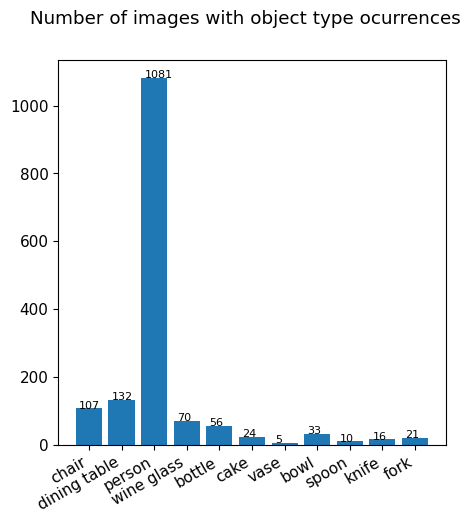

In [5]:
%matplotlib inline
object_classes_interest = ['person','bottle','wine glass','fork','knife','spoon','bowl','cake','chair','dining table','vase']
nodes = imagesGraphDB.get_nodes() #devuelve un diccionario iterable
object_class_names = []
number_images_with_class_ocurrence =[]
for node in nodes:
    if node in object_classes_interest :
        neighbors = imagesGraphDB.get_neighbours(node)
        object_class_names.append(node)
        number_images_with_class_ocurrence.append(len(list(neighbors)))

fig, ax = plt.subplots(figsize=(5,5))
fig.suptitle('Number of images with object type ocurrences')
ax.bar(object_class_names,number_images_with_class_ocurrence)
plt.xticks(rotation=30, ha='right')
for i in range(len(object_class_names)):
    plt.text(x = i-0.3 , y = number_images_with_class_ocurrence[i], s = number_images_with_class_ocurrence[i], size = 8)
plt.show()

### 3.1.2. Muestra de imágenes con "pastel" y "personas" detectadas

In [7]:
# Se cargan los datos desde un fichero gml de los objetos detectados
imagesGraphDB = ImagesGraphDB()
imagesGraphDB.load_graph_from_gml_file(PATH_COCO_GML_FILE)

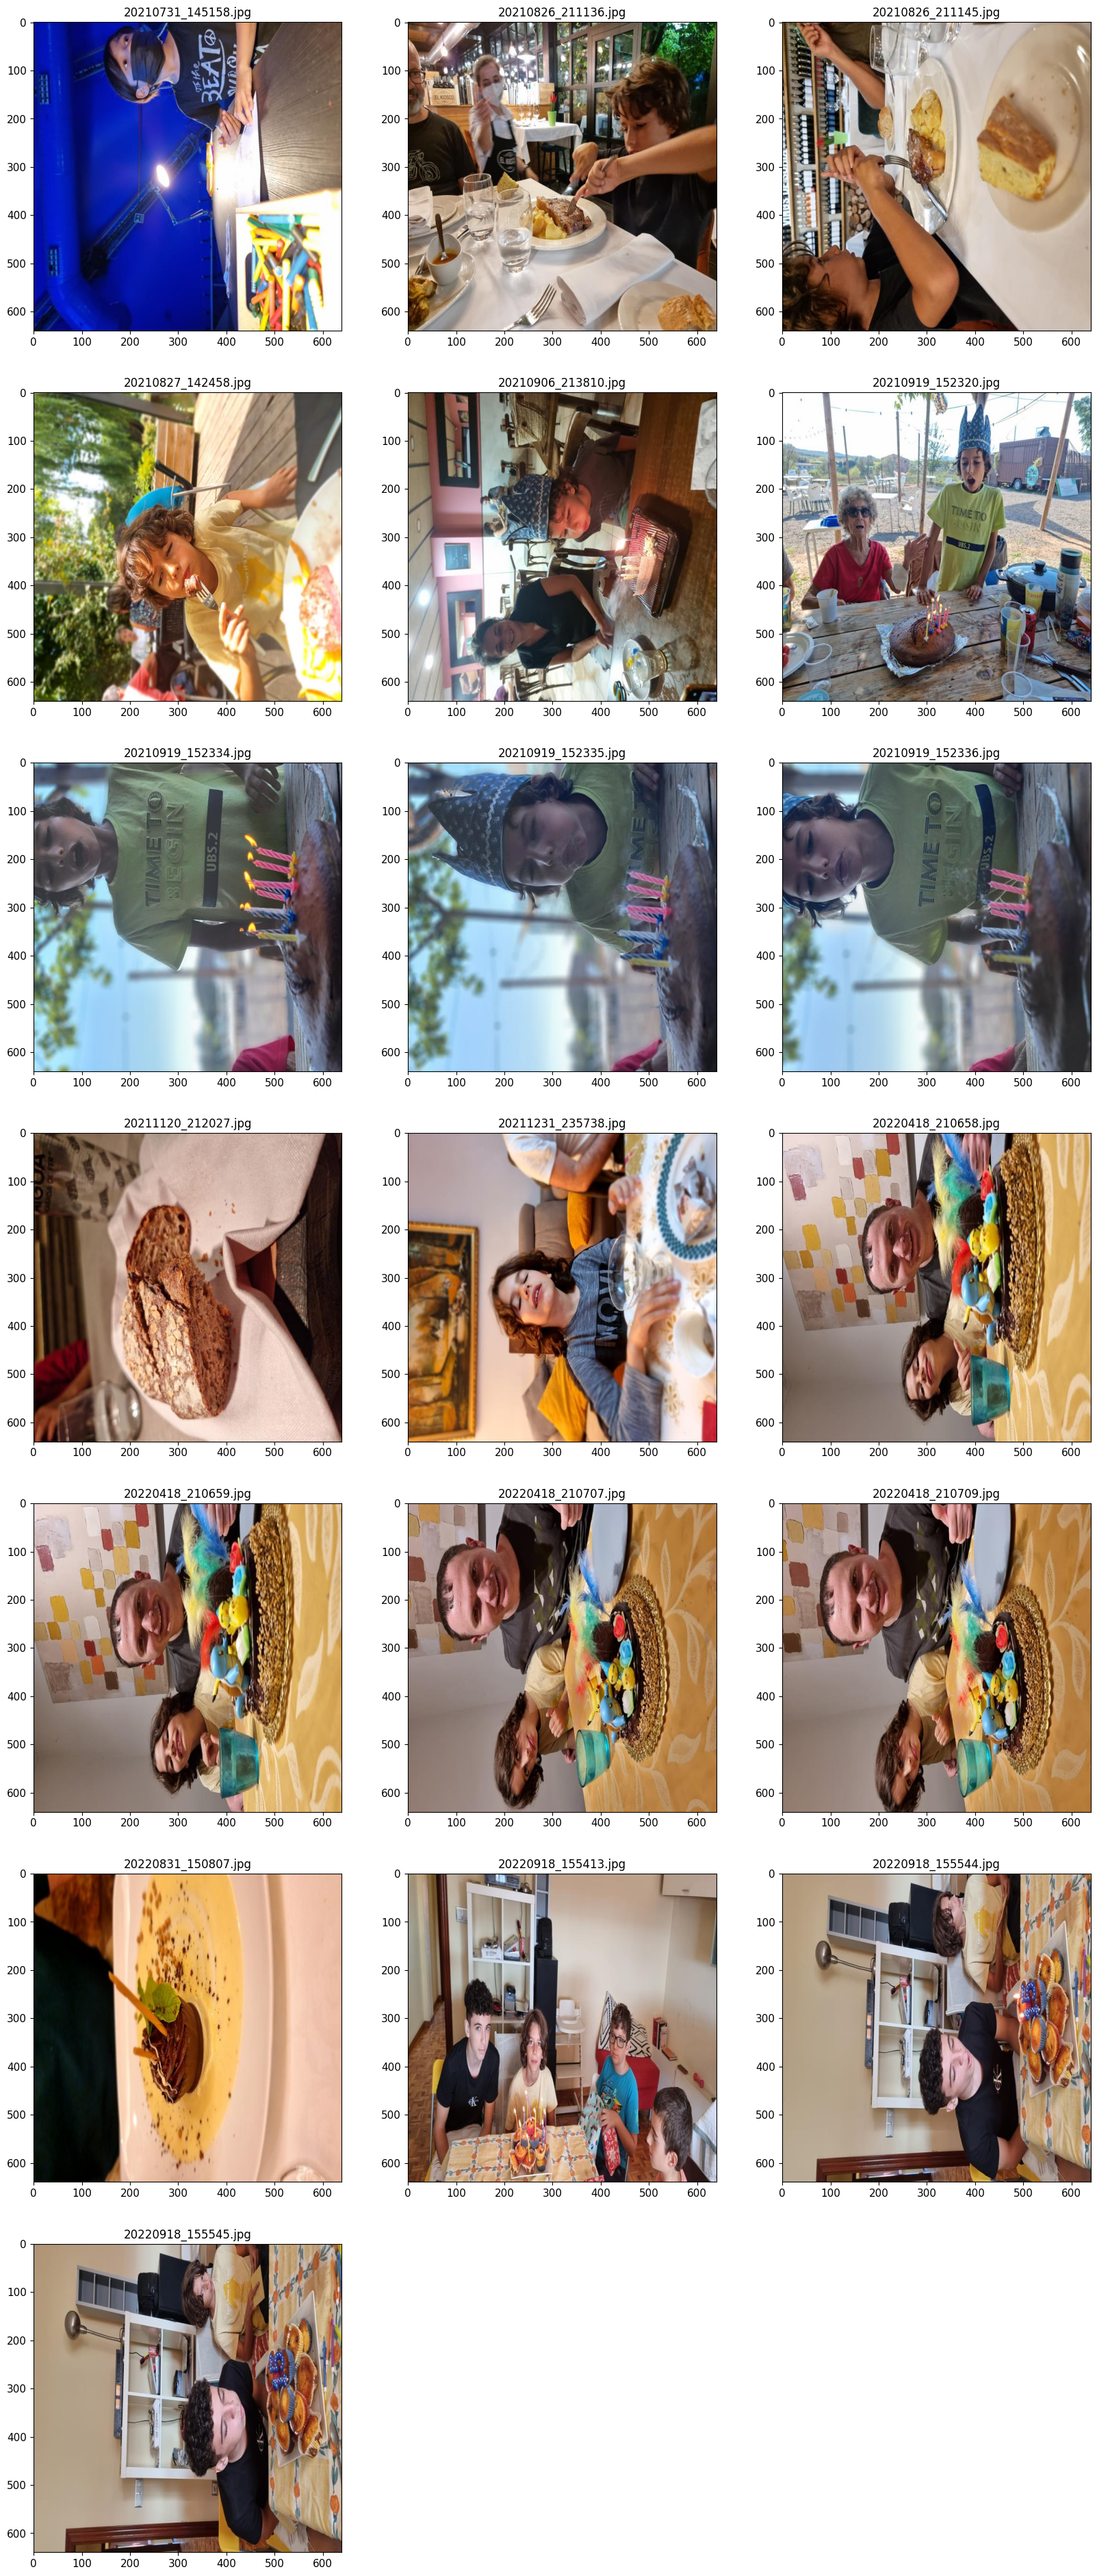

In [8]:
# Se obtiene las imágenes del grafo que se relacionan con los nodos "person" y "cake"
object_classes_to_filter = ['cake','person'] # Se cogerán las imagenes con pastels y personas
neighbors_cake = imagesGraphDB.get_images_containing_list_object_types(object_classes_to_filter)
cake_images_filepath_list = []
cake_images_filename_list = []
for neighbor_cake in neighbors_cake:
    cake_images_filepath_list.append(os.path.join(PATH_IMAGENES_RESIZED,neighbor_cake))
    cake_images_filename_list.append(neighbor_cake)

# Se cargan las imágenes en formato PIL en una lista pora poderlas mostrar en un grid
images_rgb_list= []
for i, image in enumerate(cake_images_filepath_list):
    image_rgb = Image.open(image)
    images_rgb_list.append(image_rgb)

# Se muestran las imagenes en un grid usando un metodo propio del helper de imágenes
%matplotlib inline
ImageHelper.display_images(images_rgb_list,columns=3,max_images=20,label_font_size=12)

Se observan falsos positivos al identificar comidas como pasteles por tener formas similares.